In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, HeteroData
from torch_geometric.nn import MessagePassing, GATConv
from torch_geometric.utils import softmax, add_self_loops, from_networkx
import numpy as np
import math
import pandas as pd
import networkx as nx
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import defaultdict
from torch.nn.functional import cosine_similarity
import random

In [ ]:
def load_hetero_graph(csv_path):
    df = pd.read_csv(csv_path)
    df['customer'] = df['customer'].str.strip("'")
    df['merchant'] = df['merchant'].str.strip("'")
    df['category'] = df['category'].str.strip("'")
    df['gender'] = df['gender'].str.strip("'")
    df['age'] = df['age'].str.strip("'").replace('U', -1).astype(int)

    cust_enc = LabelEncoder()
    merch_enc = LabelEncoder()
    cat_enc = LabelEncoder()

    df['customer_id'] = cust_enc.fit_transform(df['customer'])
    df['merchant_id'] = merch_enc.fit_transform(df['merchant'])
    df['category_id'] = cat_enc.fit_transform(df['category'])

    # Save for transaction list
    df['transaction_id'] = df.index

    data_pg = HeteroData()
    # Customer node features: [age, gender]
    gender_map = {'M': 0, 'F': 1}
    gender_feat = df.groupby('customer_id')['gender'].first().map(gender_map).fillna(0).astype(int)
    data_pg['customer'].x = torch.tensor(
        df.groupby('customer_id')['age'].mean().values, dtype=torch.float
    ).unsqueeze(1)
    data_pg['customer'].x = torch.cat([data_pg['customer'].x, torch.tensor(gender_feat.values).unsqueeze(1)], dim=1)

    # Merchant node features: [category_id]
    merch_cat = df.groupby('merchant_id')['category_id'].first().fillna(0).astype(int)
    data_pg['merchant'].x = torch.tensor(merch_cat.values).unsqueeze(1).float()

    # Edges: from customer → merchant
    src = torch.tensor(df['customer_id'].values, dtype=torch.long)
    dst = torch.tensor(df['merchant_id'].values, dtype=torch.long)
    data_pg['customer', 'transaction', 'merchant'].edge_index = torch.stack([src, dst], dim=0)

    # Edge features: amount, step (as timestamp), fraud
    edge_attr = torch.tensor(df[['amount', 'step', 'fraud']].values, dtype=torch.float)
    data_pg['customer', 'transaction', 'merchant'].edge_attr = edge_attr

    return data_pg, df

In [ ]:
def transform_hetero_to_transaction_graph(data_pg):
    edge_index = data_pg['customer', 'transaction', 'merchant'].edge_index
    edge_attr = data_pg['customer', 'transaction', 'merchant'].edge_attr
    transactions = []

    for i in range(edge_index.shape[1]):
        transaction = {
            "id": i,
            "customer": edge_index[0, i].item(),
            "merchant": edge_index[1, i].item(),
            "amount": edge_attr[i][0].item(),
            "timestamp": edge_attr[i][1].item(),
            "is_fraud": int(edge_attr[i][2].item())
        }
        transactions.append(transaction)
    return transactions, len(transactions)

In [ ]:
def build_transaction_adjacency(transactions, time_window=100, benign_sample_frac=0.05):
    df = pd.DataFrame(transactions)
    df = df.copy()
    df['timestamp_bin'] = (df['timestamp'] / time_window).astype(int)

    # Reduce to fraud + sampled benign
    frauds = df[df['is_fraud'] == 1]
    benign = df[df['is_fraud'] == 0].sample(frac=benign_sample_frac, random_state=42)
    df_subset = pd.concat([frauds, benign]).reset_index(drop=True)
    df_subset['new_id'] = df_subset.index

    # Preload numpy arrays
    timestamps = df_subset['timestamp'].values
    customers = df_subset['customer'].values
    merchants = df_subset['merchant'].values
    bins = df_subset['timestamp_bin'].values

    # Inverted index: bin → customer/merchant → row indices
    cust_bin_index = defaultdict(list)
    merch_bin_index = defaultdict(list)
    for i, (c, m, b) in enumerate(zip(customers, merchants, bins)):
        cust_bin_index[(c, b)].append(i)
        merch_bin_index[(m, b)].append(i)

    MAX_NEIGHBORS_PER_TX = 200
    edge_src = []
    edge_dst = []
    edge_weights = []

    for i in range(len(df_subset)):
        print(i, "/", len(df_subset))
        src = i
        c, m, b = customers[i], merchants[i], bins[i]
        t_src = timestamps[i]

        neighbors = set()
        for bb in [b - 1, b, b + 1]:
            neighbors.update(cust_bin_index.get((c, bb), []))
            neighbors.update(merch_bin_index.get((m, bb), []))
        neighbors.discard(i)

        for dst in list(neighbors)[:MAX_NEIGHBORS_PER_TX]:
            dt = abs(t_src - timestamps[dst])
            edge_src.append(i)
            edge_dst.append(dst)
            edge_weights.append(1.0 / (1.0 + dt))

    edge_index = torch.tensor([edge_src, edge_dst], dtype=torch.long)
    edge_attr = torch.tensor(edge_weights, dtype=torch.float)

    return edge_index, edge_attr, df_subset.to_dict("records")

In [ ]:
def prepare_asagnn_inputs(transactions):
    X = torch.tensor([[tx['amount'], tx['timestamp']] for tx in transactions], dtype=torch.float)
    y = torch.tensor([tx['is_fraud'] for tx in transactions], dtype=torch.long)
    return X, y

In [ ]:
def build_asagnn_edges(X, edge_index_sparse, weight_sparse, top_k=20, cos_exp=True):
    from collections import defaultdict
    from torch.nn.functional import cosine_similarity

    src_all = edge_index_sparse[0].cpu()
    dst_all = edge_index_sparse[1].cpu()
    weight_sparse = weight_sparse.cpu()

    grouped = defaultdict(list)

    for i in range(edge_index_sparse.shape[1]):
        print(i, "/", edge_index_sparse.shape[1])
        src = src_all[i].item()
        dst = dst_all[i].item()
        w = weight_sparse[i].item()

        src_vec = X[src]
        dst_vec = X[dst]
        sim = cosine_similarity(src_vec.unsqueeze(0), dst_vec.unsqueeze(0), dim=1).item()
        if cos_exp:
            sim = np.exp(sim)

        grouped[src].append((dst, sim, w))

    edge_index = []
    edge_attr = []

    for src, triples in grouped.items():
        print(src, "/", len(grouped))
        # keep only top-k by sim
        if len(triples) > 500:
            triples = random.sample(triples, 500)
        topk = sorted(triples, key=lambda x: -x[1])[:top_k]
        for dst, _, w in topk:
            edge_index.append([src, dst])
            edge_attr.append(w)

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    return edge_index, edge_attr

In [ ]:
def run_asagnn_preproc_pipeline(data_pg):
    transactions, num_tx = transform_hetero_to_transaction_graph(data_pg)
    print(num_tx)
    edge_index, edge_attr, reduced_tx = build_transaction_adjacency(transactions)
    print(edge_index.shape[0])
    X, is_fraud = prepare_asagnn_inputs(reduced_tx)
    MAX_EDGES = 20_000_000
    if edge_index.shape[1] > MAX_EDGES:
        print(f"Too many edges: {edge_index.shape[1]}, trimming to {MAX_EDGES}...")
        edge_index = edge_index[:, :MAX_EDGES]
        edge_attr = edge_attr[:MAX_EDGES]
    edge_index_asagnn, edge_weight_asagnn = build_asagnn_edges(
        X, edge_index, edge_attr, top_k=20, cos_exp=True
    )
    return Data(x=X, y=is_fraud, edge_index=edge_index_asagnn, edge_attr=edge_weight_asagnn)


In [ ]:
# Transform Hetero Data to Homo

In [ ]:
data_pg, df = load_hetero_graph("/content/bs140513_032310.csv")
data_homo = run_asagnn_preproc_pipeline(data_pg)

Streaming output truncated to the last 5000 lines.
31572 / 36572
31573 / 36572
31574 / 36572
31575 / 36572
31576 / 36572
31577 / 36572
31578 / 36572
31579 / 36572
31580 / 36572
31581 / 36572
31582 / 36572
31583 / 36572
31584 / 36572
31585 / 36572
31586 / 36572
31587 / 36572
31588 / 36572
31589 / 36572
31590 / 36572
31591 / 36572
31592 / 36572
31593 / 36572
31594 / 36572
31595 / 36572
31596 / 36572
31597 / 36572
31598 / 36572
31599 / 36572
31600 / 36572
31601 / 36572
31602 / 36572
31603 / 36572
31604 / 36572
31605 / 36572
31606 / 36572
31607 / 36572
31608 / 36572
31609 / 36572
31610 / 36572
31611 / 36572
31612 / 36572
31613 / 36572
31614 / 36572
31615 / 36572
31616 / 36572
31617 / 36572
31618 / 36572
31619 / 36572
31620 / 36572
31621 / 36572
31622 / 36572
31623 / 36572
31624 / 36572
31625 / 36572
31626 / 36572
31627 / 36572
31628 / 36572
31629 / 36572
31630 / 36572
31631 / 36572
31632 / 36572
31633 / 36572
31634 / 36572
31635 / 36572
31636 / 36572
31637 / 36572
31638 / 36572
31639 / 365

In [ ]:
torch.save(data_homo, "smaller_data.pt")

In [ ]:
data_homo = torch.load("/content/smaller_data.pt", weights_only=False)

Actual GNN Below

In [ ]:
def neighbor_diversity_entropy(node_id, neighbors, labels):
    """
    Compute the entropy of the neighbor labels for node_id.
    neighbors: list of node IDs
    labels: Tensor of shape [num_nodes], in {0,1}
    """
    if len(neighbors) == 0:
        return 0.0
    n_fraud = sum(labels[nb].item() for nb in neighbors)
    n_legit = len(neighbors) - n_fraud
    if len(neighbors) == 0:
        return 0.0
    p_f = n_fraud / len(neighbors)
    p_l = n_legit / len(neighbors)
    eps = 1e-12
    # standard binary entropy
    entropy = 0.0
    if p_f > 0:
        entropy -= p_f * math.log(p_f+eps)
    if p_l > 0:
        entropy -= p_l * math.log(p_l+eps)
    return entropy

In [ ]:
def time_decay_weight(t_v, t_nb, all_nb_times):
    dist = abs(t_v - t_nb)
    denom = 0.0
    for t_u in all_nb_times:
        denom += math.sqrt(abs(t_v - t_u))
    num = math.sqrt(dist)
    if denom < 1e-12:
        return 1.0
    return num / denom

In [ ]:
class ASA_GNN_Layer(nn.Module):
    """
    One layer of the ASA-GNN approach that:
      - Re-selects neighbors for each node using hidden features => top-K
      - Oversamples if node is fraud
      - Time-based weighting for attention
      - neighbor diversity gating
      - final update => concat(own, gating*neighbors) => linear => relu
    """
    def __init__(self, in_dim, out_dim, top_k=20, dropout=0.2):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.top_k = top_k

        # For the final transform
        # We'll take [in_dim + in_dim], since we do concat(own, aggregator)
        self.linear = nn.Linear(in_dim*2, out_dim)
        self.dropout = nn.Dropout(dropout)
        self.leakyrelu = nn.LeakyReLU(0.2)

        # For gating, we need to do a BN on the entropies
        self.batchnorm = nn.BatchNorm1d(num_features=1, affine=False)

    def forward(
        self,
        h_in,          # [num_nodes, in_dim], hidden states from previous layer
        adjacency,     # {node_id: [neighbors]}
        edge_weight,   # {(v,nb): w}
        node_time,     # [num_nodes], transaction time for each node
        labels,        # [num_nodes], 0 or 1
        device=None
    ):
        num_nodes = h_in.size(0)

        # We'll store neighbor sets, aggregator, gating
        aggregator_out = torch.zeros_like(h_in)

        # We'll also store each node's neighbor diversity for gating
        entropies = torch.zeros(num_nodes, dtype=torch.float, device=device)

        # Pre-normalize h_in for cos-sim
        h_norm = F.normalize(h_in, p=2, dim=1)

        # Build the neighbor set for each node using top_k
        new_neighbors_dict = {}
        for v in range(num_nodes):
            if v not in adjacency:
                new_neighbors_dict[v] = []
                continue

            # compute (weight * cos_sim) with each neighbor
            scores = []
            v_feat = h_norm[v]  # shape => [in_dim]
            for nb in adjacency[v]:
                w = edge_weight.get((v, nb), 0.0)
                cos_sim = torch.dot(v_feat, h_norm[nb]).item()
                # total score
                total_sc = w * math.exp(cos_sim)  # as the paper uses e^(cos_sim)
                scores.append((nb, total_sc))

            # sort descending
            scores.sort(key=lambda x: x[1], reverse=True)
            selected = scores[:self.top_k]

            # oversample if v is fraud
            if labels[v] == 1:
                # find additional neighbors that are fraud
                # with some threshold
                for (nb, sc) in scores[self.top_k:]:
                    if labels[nb] == 1 and sc >= 0.3:  # threshold
                        selected.append((nb, sc))

            new_neighbors_dict[v] = [nb for (nb, sc) in selected]

        # compute neighbor diversity => entropies
        for v in range(num_nodes):
            nb_list = new_neighbors_dict[v]
            e = neighbor_diversity_entropy(v, nb_list, labels)
            entropies[v] = e

        # Batch-norm these entropies => shape => [num_nodes,1], so we unsqueeze
        entropies_in = entropies.unsqueeze(1)
        normed = self.batchnorm(entropies_in)  # shape => [num_nodes,1]
        # gating factor: g_v = sigma( -normed )
        gating = torch.sigmoid(-normed).squeeze(1)  # => [num_nodes]

        # Weighted Attention with time-based factor
        a_param = nn.Parameter(torch.empty(self.in_dim*2, 1, device=device))
        nn.init.xavier_uniform_(a_param.data, gain=1.414)

        # aggregator
        aggregator_out = torch.zeros_like(h_in).to(h_in.device)
        for v in range(num_nodes):
            v_feat = h_in[v] # shape => [in_dim]
            neighbors = new_neighbors_dict[v]
            if len(neighbors) == 0:
                # aggregator => 0 => aggregator_out[v] = 0
                aggregator_out[v] = torch.zeros_like(v_feat)
                continue

            # gather neighbor feats
            nb_feats = h_in[neighbors]  # shape => [num_nb, in_dim]
            # expand v_feat => shape => [num_nb, in_dim]
            v_exp = v_feat.unsqueeze(0).repeat(len(neighbors), 1)
            # cat => shape => [num_nb, 2*in_dim]
            cat_feat = torch.cat([v_exp, nb_feats], dim=1).to(h_in.device)
            # compute e_ij => shape => [num_nb,1]
            e_ij = self.leakyrelu(cat_feat @ a_param).to(h_in.device)

            # time-based weighting
            times_nb = [node_time[nb].item() for nb in neighbors]
            out_alpha = []
            for i, nb in enumerate(neighbors):
                decay = time_decay_weight(node_time[v].item(), node_time[nb].item(), times_nb)
                out_alpha.append(e_ij[i].item() * decay)

            alpha_torch = torch.tensor(out_alpha, dtype=torch.float, device=h_in.device)
            # softmax
            alpha = F.softmax(alpha_torch, dim=0).unsqueeze(1) # [num_nb, 1]
            # aggregator => sum_{nb} alpha_{v,nb} * h_nb
            nb_agg = torch.sum(alpha * nb_feats, dim=0)
            aggregator_out[v] = nb_agg

        # gating + concat => final transform
        # new_h_v = ReLU( linear( concat( h_in[v], g_v * aggregator ) ) )
        new_h = torch.zeros(num_nodes, self.linear.out_features, device=h_in.device)
        for v in range(num_nodes):
            g_v = gating[v].to(h_in.device)
            combined = torch.cat([h_in[v], g_v * aggregator_out[v]], dim=0).to(h_in.device) # shape => [2*in_dim]
            tmp = self.linear(combined)
            tmp = F.relu(tmp)
            new_h[v] = tmp

        new_h = self.dropout(new_h)
        return new_h

In [ ]:
class ASA_GNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_layers=2, top_k=20):
        super().__init__()
        self.layers = nn.ModuleList()
        dims = [in_dim] + [hidden_dim]*(num_layers)
        for i in range(num_layers):
            self.layers.append(
                ASA_GNN_Layer(dims[i], dims[i+1], top_k=top_k)
            )
        self.classifier = nn.Linear(dims[-1], out_dim)

    def forward(
        self,
        X,
        adjacency,       # {node: [neighbors]}
        edge_weight,     # {(v,nb): w}
        node_time,       # [num_nodes]
        labels,
        device=None
    ):
        h = X
        for layer in self.layers:
            h = layer(h, adjacency, edge_weight, node_time, labels, device)
        logits = self.classifier(h)
        return logits

Training

In [ ]:
from collections import defaultdict

In [ ]:
def pyg_to_asagnn_dict(data):
    """
    data: a PyG Data object with .edge_index [2, M]
          and possibly .edge_attr [M] or [M, dim]

    Returns:
      adjacency: dict { v: [neighbors] }
      weight_dict: dict { (v, nb): weight }
    """
    adjacency = defaultdict(list)
    weight_dict = {}

    e_idx = data.edge_index
    e_attr = data.edge_attr
    if e_attr is None:
        e_attr = torch.ones(e_idx.size(1), dtype=torch.float)

    M = e_idx.size(1)
    for i in range(M):
        v  = e_idx[0, i].item()
        nb = e_idx[1, i].item()

        if e_attr.dim() == 1:
            w = float(e_attr[i].item())
        else:
            w = float(e_attr[i, 0].item())

        adjacency[v].append(nb)
        weight_dict[(v, nb)] = w

        adjacency[nb].append(v)
        weight_dict[(nb, v)] = w

    return adjacency, weight_dict

In [ ]:
adjacency, weight_dict = pyg_to_asagnn_dict(data_homo)

num_nodes = data_homo.num_nodes
indices = torch.randperm(num_nodes)

train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_end = int(train_ratio * num_nodes)
val_end = int((train_ratio + val_ratio) * num_nodes)

train_idx = indices[:train_end]
val_idx = indices[train_end:val_end]
test_idx = indices[val_end:]

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask   = torch.zeros(num_nodes, dtype=torch.bool)
test_mask  = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx]     = True
test_mask[test_idx]   = True

data_homo.train_mask = train_mask
data_homo.val_mask   = val_mask
data_homo.test_mask  = test_mask

In [ ]:
# from torch_geometric.utils import subgraph
# def get_small_subgraph(data, num_nodes_sample=100):
#     # Randomly sample a subset of nodes
#     subset = torch.randperm(data.num_nodes)[:num_nodes_sample]
#     # Extract the subgraph induced by these nodes.
#     # The `relabel_nodes=True` flag ensures that node indices are re-mapped to 0,...,num_nodes_sample-1.
#     sub_edge_index, sub_edge_attr = subgraph(
#         subset, data.edge_index, data.edge_attr, relabel_nodes=True
#     )

#     # Create a new Data object with the sampled nodes.
#     sub_data = data.__class__(x=data.x[subset],
#                               edge_index=sub_edge_index,
#                               edge_attr=sub_edge_attr,
#                               y=data.y[subset])

#     # Optionally, if you have train/val/test masks, sample them too:
#     if hasattr(data, 'train_mask'):
#         sub_data.train_mask = data.train_mask[subset]
#         sub_data.val_mask = data.val_mask[subset]
#         sub_data.test_mask = data.test_mask[subset]

#     return sub_data

# # Usage:
# data_homo = get_small_subgraph(data_homo, num_nodes_sample=2000)

In [ ]:
# train
model = ASA_GNN(in_dim=data_homo.x.size(1), hidden_dim=32, out_dim=1, num_layers=3, top_k=20)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
X = data_homo.x.to(device)
labels = data_homo.y.clone()
labels = labels.long().to(device)

train_idx = data_homo.train_mask.nonzero(as_tuple=True)[0].to(device)
val_idx = data_homo.val_mask.nonzero(as_tuple=True)[0].to(device)
test_idx = data_homo.test_mask.nonzero(as_tuple=True)[0].to(device)

print(len(train_idx), len(val_idx), len(test_idx))

21943 7314 7315


In [ ]:
node_time = torch.zeros(X.size(0), device=device)

In [ ]:
model.to(device)
data_homo.to(device)

Data(x=[36572, 2], edge_index=[2, 731357], edge_attr=[731357], y=[36572], train_mask=[36572], val_mask=[36572], test_mask=[36572])

In [ ]:
for epoch in range(1, epochs+1):
    model.train()
    optimizer.zero_grad()
    logits = model(X, adjacency, weight_dict, node_time, labels, device)

    train_logits = logits[train_idx].view(-1)
    train_labels = labels[train_idx].float().view(-1)
    loss = criterion(train_logits, train_labels)
    loss.backward()
    optimizer.step()
    print("Current Epoch: ", epoch, " | Loss: ", loss.item())
    # Validation
    if epoch%5==0 or epoch==epochs:
            model.eval()
            with torch.no_grad():
                val_logits = model(X, adjacency, weight_dict, node_time, labels, device)
                val_out    = val_logits[val_idx].view(-1)
                val_lbl    = labels[val_idx].float().view(-1)
                val_loss   = criterion(val_out, val_lbl)

                # compute metrics
                val_prob = torch.sigmoid(val_out)
                val_pred = (val_prob>=0.5).long()
                val_acc  = (val_pred == val_lbl).float().mean().item()
            print(f"val_loss={val_loss.item():.4f}, val_acc={val_acc:.4f}")


Current Epoch:  1  | Loss:  1.510467767715454
Current Epoch:  2  | Loss:  1.3758774995803833
Current Epoch:  3  | Loss:  1.288508415222168
Current Epoch:  4  | Loss:  0.7166933417320251
Current Epoch:  5  | Loss:  1.093078851699829
val_loss=0.6453, val_acc=0.7259
Current Epoch:  6  | Loss:  0.6009281873703003
Current Epoch:  7  | Loss:  0.7233129739761353
Current Epoch:  8  | Loss:  0.5227981209754944
Current Epoch:  9  | Loss:  0.5971167683601379
Current Epoch:  10  | Loss:  0.4234532117843628
val_loss=0.2955, val_acc=0.9095
Current Epoch:  11  | Loss:  0.3537568151950836
Current Epoch:  12  | Loss:  0.4348702132701874
Current Epoch:  13  | Loss:  0.4395385682582855
Current Epoch:  14  | Loss:  0.3474748730659485
Current Epoch:  15  | Loss:  0.3851204514503479
val_loss=0.2905, val_acc=0.8986
Current Epoch:  16  | Loss:  0.3229239284992218
Current Epoch:  17  | Loss:  0.32335931062698364
Current Epoch:  18  | Loss:  0.2988091707229614
Current Epoch:  19  | Loss:  0.2846910357475281
Cur

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [ ]:
#test
model.eval()
with torch.no_grad():
    test_logits = model(X, adjacency, weight_dict, node_time, labels, device)
    test_out = test_logits[test_idx].view(-1)
    test_lbl = labels[test_idx].float().view(-1)
    test_prob= torch.sigmoid(test_out)
    test_pred= (test_prob>=0.5).long()
    test_acc = (test_pred==test_lbl).float().mean().item()
print("Test Accuracy: ", test_acc)

test_lbl_cpu  = test_lbl.cpu().numpy()
test_pred_cpu = test_pred.cpu().numpy()

f1  = f1_score(test_lbl_cpu, test_pred_cpu, average="binary")
prec= precision_score(test_lbl_cpu, test_pred_cpu, average="binary")
rec = recall_score(test_lbl_cpu, test_pred_cpu, average="binary")
cm  = confusion_matrix(test_lbl_cpu, test_pred_cpu)

print(f"F1 Score:       {f1:.4f}")
print(f"Precision:      {prec:.4f}")
print(f"Recall:         {rec:.4f}")
print("Confusion Matrix:")
print(cm)

Test Accuracy:  0.9193438291549683
F1 Score:       0.7993
Precision:      0.7751
Recall:         0.8251
Confusion Matrix:
[[5550  341]
 [ 249 1175]]


In [ ]:
cm = [[5550,  341],[ 249, 1175]]

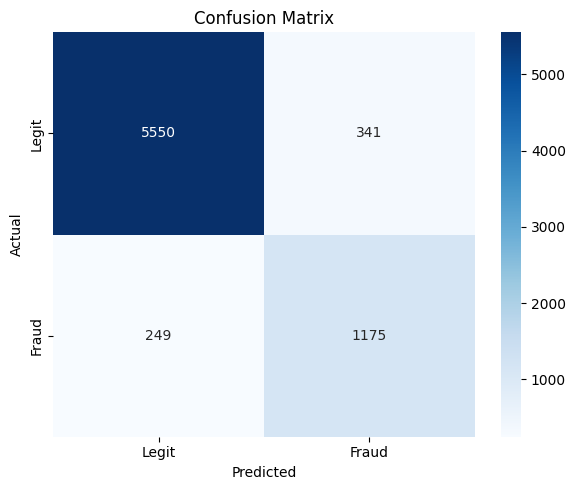

In [ ]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legit', 'Fraud'],
            yticklabels=['Legit', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Ignore this section!!!

In [ ]:
for epoch in range(1, 40+1):
    model.train()
    optimizer.zero_grad()
    logits = model(X, adjacency, weight_dict, node_time, labels, device)

    train_logits = logits[train_idx].view(-1)
    train_labels = labels[train_idx].float().view(-1)
    loss = criterion(train_logits, train_labels)
    loss.backward()
    optimizer.step()
    print("Current Epoch: ", epoch, " | Loss: ", loss.item())
    # Validation
    if epoch%5==0 or epoch==epochs:
            model.eval()
            with torch.no_grad():
                val_logits = model(X, adjacency, weight_dict, node_time, labels, device)
                val_out    = val_logits[val_idx].view(-1)
                val_lbl    = labels[val_idx].float().view(-1)
                val_loss   = criterion(val_out, val_lbl)

                # compute metrics
                val_prob = torch.sigmoid(val_out)
                val_pred = (val_prob>=0.5).long()
                val_acc  = (val_pred == val_lbl).float().mean().item()
            print(f"val_loss={val_loss.item():.4f}, val_acc={val_acc:.4f}")

Current Epoch:  1  | Loss:  2.515153646469116
Current Epoch:  2  | Loss:  1.7834635972976685
Current Epoch:  3  | Loss:  1.2466236352920532
Current Epoch:  4  | Loss:  1.3947370052337646
Current Epoch:  5  | Loss:  1.1786538362503052
val_loss=0.5867, val_acc=0.8249
Current Epoch:  6  | Loss:  0.8248973488807678
Current Epoch:  7  | Loss:  0.7761937379837036
Current Epoch:  8  | Loss:  0.672109067440033
Current Epoch:  9  | Loss:  0.7090351581573486
Current Epoch:  10  | Loss:  0.6181002855300903
val_loss=0.3468, val_acc=0.9021
Current Epoch:  11  | Loss:  0.5350748300552368
Current Epoch:  12  | Loss:  0.554732620716095
Current Epoch:  13  | Loss:  0.3894713521003723
Current Epoch:  14  | Loss:  0.467447429895401
Current Epoch:  15  | Loss:  0.4239884912967682
val_loss=0.2192, val_acc=0.8876
Current Epoch:  16  | Loss:  0.3722935914993286
Current Epoch:  17  | Loss:  0.34551793336868286
Current Epoch:  18  | Loss:  0.31985846161842346
Current Epoch:  19  | Loss:  0.3308018147945404
Cur

In [ ]:
#test
model.eval()
with torch.no_grad():
    test_logits = model(X, adjacency, weight_dict, node_time, labels, device)
    test_out = test_logits[test_idx].view(-1)
    test_lbl = labels[test_idx].float().view(-1)
    test_prob= torch.sigmoid(test_out)
    test_pred= (test_prob>=0.5).long()
    test_acc = (test_pred==test_lbl).float().mean().item()
    loss = criterion(test_out, test_lbl)
print("Test Accuracy: ", test_acc)

test_lbl_cpu  = test_lbl.cpu().numpy()
test_pred_cpu = test_pred.cpu().numpy()

f1  = f1_score(test_lbl_cpu, test_pred_cpu, average="binary")
prec= precision_score(test_lbl_cpu, test_pred_cpu, average="binary")
rec = recall_score(test_lbl_cpu, test_pred_cpu, average="binary")
cm  = confusion_matrix(test_lbl_cpu, test_pred_cpu)

print(f"F1 Score:       {f1:.4f}")
print(f"Precision:      {prec:.4f}")
print(f"Recall:         {rec:.4f}")
print("Confusion Matrix:")
print(cm)

Test Accuracy:  0.8891319632530212
F1 Score:       0.7501
Precision:      0.6826
Recall:         0.8324
Confusion Matrix:
[[5287  566]
 [ 245 1217]]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from matplotlib.patches import Patch

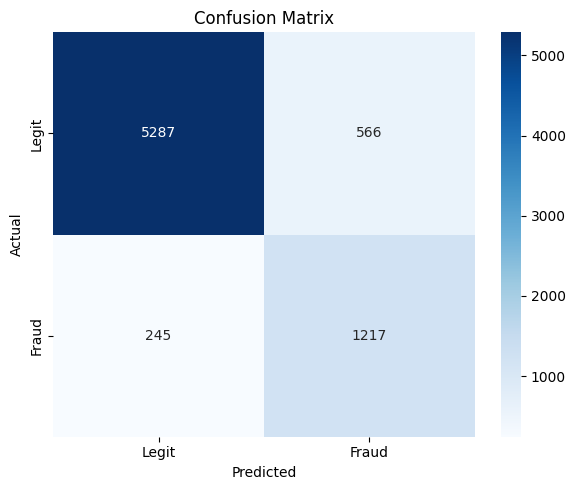

In [ ]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legit', 'Fraud'],
            yticklabels=['Legit', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Ignore everything under this

In [ ]:
df = pd.read_csv("/content/bs140513_032310.csv")

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import kneighbors_graph

In [ ]:
# 1. Load and preprocess data

features = df[["step", "age", "amount"]].copy()
features['age'] = pd.to_numeric(features['age'].astype(str).str.strip("'"), errors='coerce')
features.dropna(inplace=True)
labels = df.loc[features.index, "fraud"].values

X, _, y, _ = train_test_split(features, labels, stratify=labels, train_size=10000, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

def create_knn_graph(X, y, k=10):
    edge_index = kneighbors_graph(X, k, mode='connectivity', include_self=False).nonzero()
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    x = torch.tensor(X, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)

train_data = create_knn_graph(X_train, y_train, k=10)
test_data = create_knn_graph(X_test, y_test, k=10)

<ipython-input-24-5aaa7e8d0dc2>:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  edge_index = torch.tensor(edge_index, dtype=torch.long)


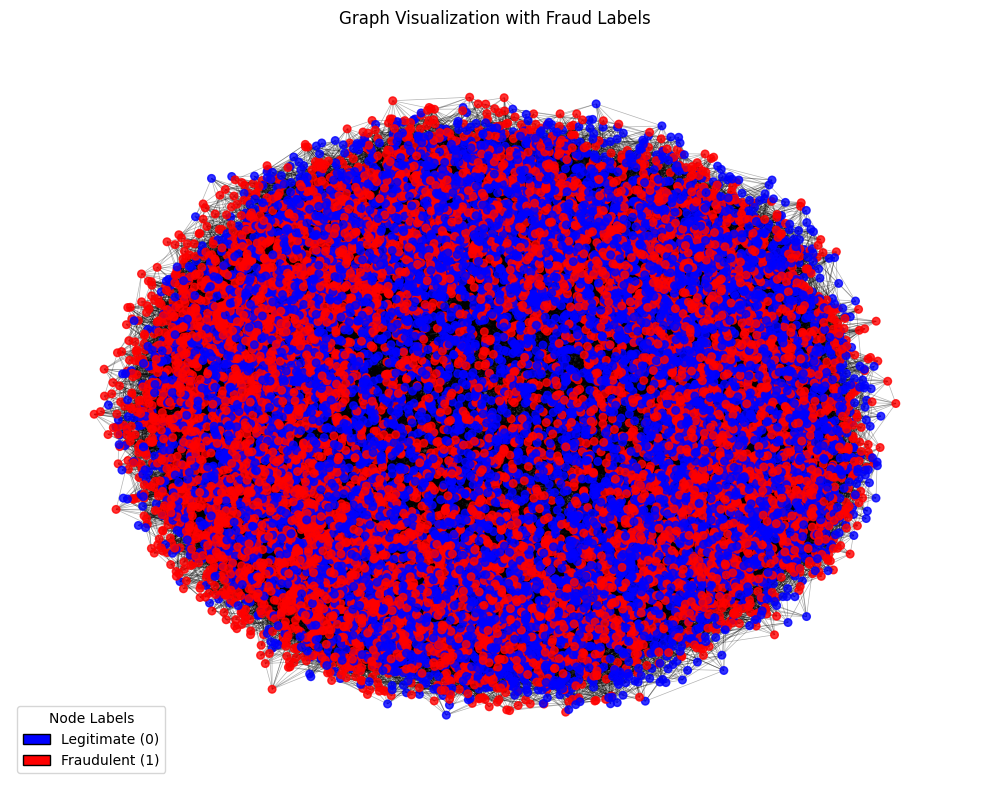

In [ ]:
import networkx as nx
from torch_geometric.utils import to_networkx

# Convert to NetworkX graph (undirected for visualization)
G = to_networkx(train_data, to_undirected=True)

# Node colors by label
node_labels = train_data.y.numpy()
node_colors = ['red' if label == 1 else 'blue' for label in node_labels]

# Create spring layout
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42, k=0.1)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30, alpha=0.8)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)

# Legend manually
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', edgecolor='k', label='Legitimate (0)'),
    Patch(facecolor='red', edgecolor='k', label='Fraudulent (1)')
]
plt.legend(handles=legend_elements, title='Node Labels', loc='lower left')

# Optional: add node labels (if graph is small)
# label_dict = {i: str(train_data.y[i].item()) for i in range(len(train_data.y))}
# nx.draw_networkx_labels(G, pos, labels=label_dict, font_size=6)

plt.title("Graph Visualization with Fraud Labels")
plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
adjacency_train, weight_dict_train = pyg_to_asagnn_dict(train_data)
adjacency_test, weight_dict_test = pyg_to_asagnn_dict(test_data)

In [ ]:
learning_rates = [0.001, 0.005, 0.01]
hidden_dims = [16, 32, 64]
best_model = None
best_f1 = 0
best_config = {}

train_data.to(device)
test_data.to(device)

for lr in learning_rates:
    for hidden_dim in hidden_dims:
        print(f"\n🔍 Testing config: LR={lr}, Hidden={hidden_dim}")
        model = ASA_GNN(train_data.num_features, hidden_dim, out_dim=1, num_layers=3, top_k=20)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.BCEWithLogitsLoss()
        model.to(device)
        train_data.to(device)
        test_data.to(device)
        node_time = torch.zeros(train_data.num_features, device=device)
        node_time_test = torch.zeros(test_data.num_features, device=device)

        # 4. Train the model (fast and memory-efficient)
        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            out = model(train_data.x, adjacency_train, weight_dict_train, node_time, train_data.y, device)
            loss = criterion(out, train_data.y)
            loss.backward()
            optimizer.step()
            #print(f"Epoch {epoch+10}, Loss: {loss.item():.4f}")
            # Print loss every 10 epochs
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

        # Evaluate
        model.eval()
        with torch.no_grad():
            logits = model(test_data.x, adjacency_test, weight_dict_test, node_time, test_data.y, device)
            probs= torch.sigmoid(test_out)

        # Threshold sweep
        thresholds = torch.linspace(0, 1, 100)
        for thresh in thresholds:
            preds = (probs >= thresh.item()).astype(int)
            f1 = f1_score(test_data.y, preds, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_model = model
                best_config = {"lr": lr, "hidden_dim": hidden_dim, "threshold": thresh.item()}


🔍 Testing config: LR=0.001, Hidden=16


IndexError: index 13572 is out of bounds for dimension 0 with size 3

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
# 5. Final Evaluation
print(f"\n✅ Best Config: {best_config}")
with torch.no_grad():
    final_probs = F.softmax(best_model(test_data.x, test_data.edge_index), dim=1)[:, 1].detach().numpy()
final_preds = (final_probs >= best_config["threshold"]).astype(int)


acc = accuracy_score(y_test, final_preds)
prec = precision_score(y_test, final_preds, zero_division=0)
rec = recall_score(y_test, final_preds, zero_division=0)
f1 = f1_score(y_test, final_preds, zero_division=0)
roc = roc_auc_score(y_test, final_probs)

print(f"\n📊 Final Metrics (threshold = {best_config['threshold']:.2f})")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roc:.4f}")

In [ ]:
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legit', 'Fraud'],
            yticklabels=['Legit', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()